In [1]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving mit-bih-arrhythmia-database-1.0.0.zip to mit-bih-arrhythmia-database-1.0.0.zip


数据已解压到: mitdb/mit-bih-arrhythmia-database-1.0.0
示例文件: ['105.dat', '200.hea', '214.xws', '202.hea', '111.hea']


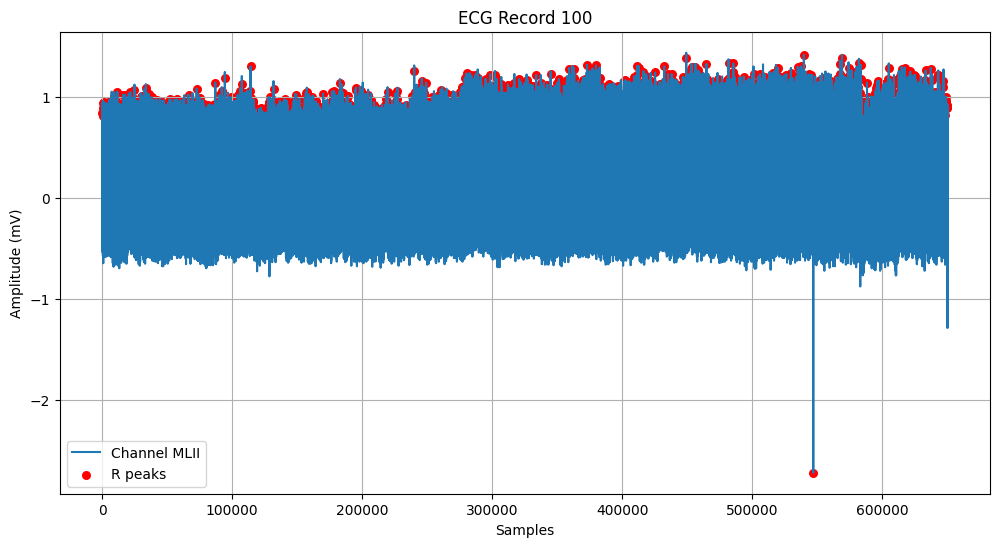


预处理结果:
- 心拍数量: 2270
- 形状: (2270, 255)
- 类别分布: {np.str_('A'): np.int64(33), np.str_('N'): np.int64(2236), np.str_('V'): np.int64(1)}


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25293 (\N{CJK UNIFIED IDEOGRAPH-62CD}) missing from font(s) DejaVu Sans.
  fig.canvas

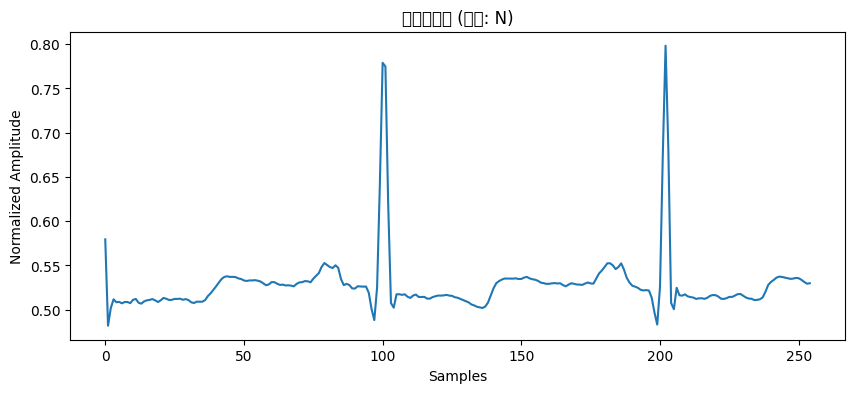

In [49]:
# -*- coding: utf-8 -*-
"""
MIT-BIH心律失常数据库处理完整代码
步骤：1.解压数据 2.加载记录 3.可视化 4.预处理
"""

import os
import zipfile
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

# =====================
# 1. 数据准备阶段
# =====================

def unzip_dataset(zip_path='mit-bih-arrhythmia-database-1.0.0.zip',
                 target_dir='mitdb'):
    """解压数据集并返回实际数据路径"""
    # 清理旧数据（如果存在）
    if os.path.exists(target_dir):
        import shutil
        shutil.rmtree(target_dir)

    # 解压文件
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)

    # 检查实际数据路径（MIT-BIH的特殊目录结构）
    actual_path = os.path.join(target_dir, 'mit-bih-arrhythmia-database-1.0.0')
    if not os.path.exists(actual_path):
        actual_path = target_dir  # 某些版本可能直接解压到目标目录

    print(f"数据已解压到: {actual_path}")
    print("示例文件:", os.listdir(actual_path)[:5])
    return actual_path

# =====================
# 2. 数据加载阶段
# =====================

def load_ecg_record(record_id, data_path):
    """安全加载ECG记录和标注"""
    try:
        # 构建完整路径（无需文件扩展名）
        record_path = os.path.join(data_path, record_id)

        # 验证必需文件是否存在
        required_files = [f'{record_path}{ext}' for ext in ['.hea', '.dat', '.atr']]
        for f in required_files:
            if not os.path.exists(f):
                raise FileNotFoundError(f"缺少文件: {f}")

        # 加载记录和标注
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')  # 注意是'atr'不是'str'

        return record, annotation

    except Exception as e:
        print(f"加载记录 {record_id} 失败: {str(e)}")
        return None, None

# =====================
# 3. 数据可视化
# =====================

def plot_ecg_with_annotations(record, annotation):
    """绘制ECG信号和标注"""
    plt.figure(figsize=(12, 6))

    # 绘制ECG信号（通常第一个通道是MLII导联）
    lead = 0 if record.n_sig > 1 else 0
    ecg_signal = record.p_signal[:, lead]
    plt.plot(ecg_signal, label=f'Channel {record.sig_name[lead]}')

    # 标注R峰位置
    r_peaks = [s for s, symbol in zip(annotation.sample, annotation.symbol)
               if symbol in ['N', 'L', 'R', 'V', 'A']]
    plt.scatter(r_peaks, ecg_signal[r_peaks], c='red', s=30, label='R peaks')

    plt.title(f"ECG Record {record.record_name}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid()
    plt.show()

# =====================
# 4. 数据预处理
# =====================

def preprocess_ecg(record, annotation, target_fs=125):
    """完整的ECG预处理流程"""
    try:
        # 选择导联（优先MLII导联）
        if 'MLII' in record.sig_name:
            lead_idx = record.sig_name.index('MLII')
        else:
            lead_idx = 0  # 默认第一个导联

        ecg_signal = record.p_signal[:, lead_idx]

        # 1. 滤波处理
        b, a = signal.butter(4, [0.5, 45], btype='bandpass', fs=record.fs)
        filtered = signal.filtfilt(b, a, ecg_signal)

        # 2. 降采样（如需要）
        if record.fs != target_fs:
            num_samples = int(len(filtered) * target_fs / record.fs)
            resampled = signal.resample(filtered, num_samples)
        else:
            resampled = filtered

        # 3. 归一化
        scaler = MinMaxScaler()
        normalized = scaler.fit_transform(resampled.reshape(-1, 1)).flatten()

        # 4. 心拍分割（基于R峰）
        beats, labels = [], []
        for i, sample in enumerate(annotation.sample):
            # 只处理主要的心拍类型
            if annotation.symbol[i] not in ['N', 'L', 'R', 'V', 'A']:
                continue

            # 计算在新采样率下的位置
            pos = int(sample * target_fs / record.fs)
            start, end = pos - 100, pos + 155  # 约1.2秒的窗口

            if start >= 0 and end <= len(normalized):
                beat = normalized[start:end]
                beats.append(beat)
                labels.append(annotation.symbol[i])

        return np.array(beats), np.array(labels)

    except Exception as e:
        print(f"预处理失败: {str(e)}")
        return None, None

# =====================
# 主执行流程
# =====================

if __name__ == "__main__":
    # 1. 解压数据
    data_path = unzip_dataset()

    # 2. 加载第一条记录
    record_id = '100'  # 示例记录
    record, ann = load_ecg_record(record_id, data_path)

    if record and ann:
        # 3. 可视化
        plot_ecg_with_annotations(record, ann)

        # 4. 预处理
        beats, labels = preprocess_ecg(record, ann)

        if beats is not None:
            print(f"\n预处理结果:")
            print(f"- 心拍数量: {len(beats)}")
            print(f"- 形状: {beats.shape}")
            print(f"- 类别分布: {dict(zip(*np.unique(labels, return_counts=True)))}")

            # 可视化第一个心拍
            plt.figure(figsize=(10, 4))
            plt.plot(beats[0])
            plt.title(f"第一个心拍 (类别: {labels[0]})")
            plt.xlabel("Samples")
            plt.ylabel("Normalized Amplitude")
            plt.show()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 180, 64)   │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 180, 64)   │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        195 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,091 (66.76 KB)

 Trainable params: 17,091 (66.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9140 - loss: 0.3152 - val_accuracy: 0.9931 - val_loss: 0.0445
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9933 - loss: 0.0436 - val_accuracy: 0.9931 - val_loss: 0.0441
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.9950 - loss: 0.0349 - val_accuracy: 0.9931 - val_loss: 0.0440
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9927 - loss: 0.0479 - val_accuracy: 0.9931 - val_loss: 0.0443
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9934 - loss: 0.0431 - val_accuracy: 0.9931 - val_loss: 0.0447
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.9905 - loss: 0.0606 - val_accuracy: 0.9931 - val_loss: 0.0439
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.9936 - loss: 0.0420 - val_accuracy: 0.9931 - val_loss: 0.0441
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9919 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


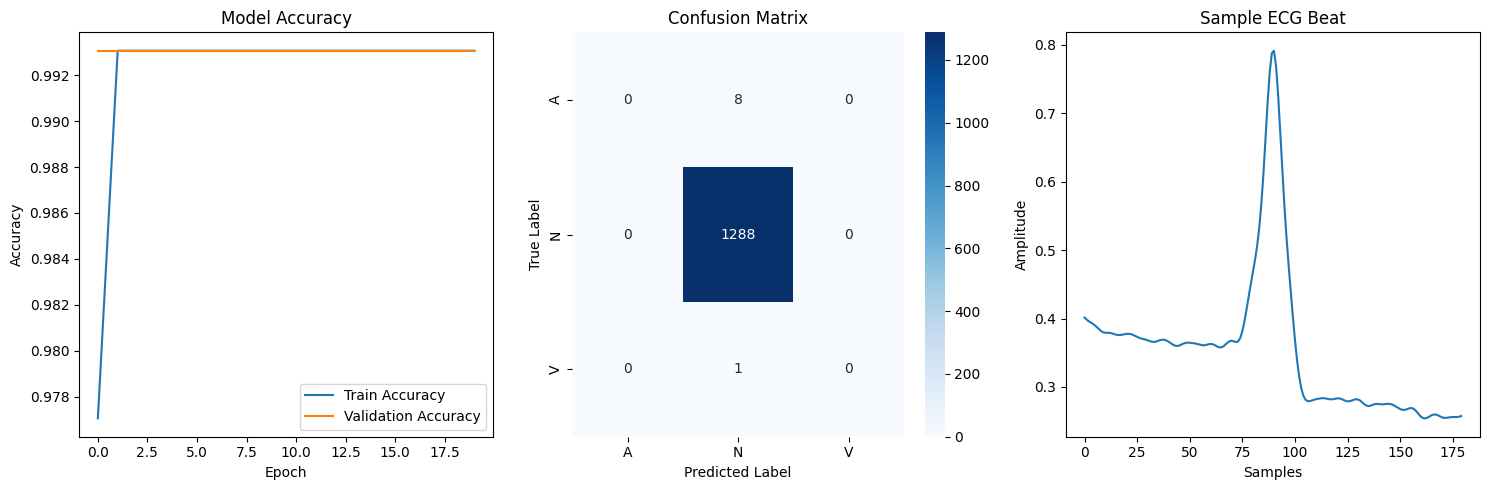

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Multiply, Concatenate, Attention

# 1. 数据预处理
def load_and_preprocess(record_ids, base_path):
    beats = []
    labels = []

    for record_id in record_ids:
        try:
            # 加载记录
            record = wfdb.rdrecord(f'{base_path}/{record_id}')
            annotation = wfdb.rdann(f'{base_path}/{record_id}', 'atr')

            # 选择MLII导联或第一个导联
            lead = 0 if 'MLII' not in record.sig_name else record.sig_name.index('MLII')
            ecg = record.p_signal[:, lead]

            # 滤波
            b, a = signal.butter(4, [0.5, 45], btype='bandpass', fs=record.fs)
            filtered = signal.filtfilt(b, a, ecg)

            # 归一化
            scaler = MinMaxScaler()
            normalized = scaler.fit_transform(filtered.reshape(-1, 1)).flatten()

            # 心拍分割
            for i, sample in enumerate(annotation.sample):
                symbol = annotation.symbol[i]
                if symbol in ['N', 'L', 'R', 'V', 'A']:  # 5个主要类别
                    start = max(0, sample - 90)
                    end = min(len(normalized), sample + 90)
                    if end - start == 180:  # 固定长度180
                        beat = normalized[start:end]
                        beats.append(beat)
                        labels.append(symbol)

        except Exception as e:
            print(f"处理记录 {record_id} 时出错: {str(e)}")

    return np.array(beats), np.array(labels)

# 2. 构建LSTM+Attention模型
def build_lstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # LSTM层
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # 注意力机制
    attention = Attention()([lstm_out, lstm_out])
    attention = tf.keras.layers.GlobalAveragePooling1D()(attention)

    # 分类器
    outputs = Dense(num_classes, activation='softmax')(attention)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# 3. 可视化函数
def plot_results(history, y_true, y_pred, class_names):
    plt.figure(figsize=(15, 5))

    # 训练过程曲线
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # 混淆矩阵
    plt.subplot(1, 3, 2)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ECG样本展示
    plt.subplot(1, 3, 3)
    sample_beat = X_train[0] if len(X_train) > 0 else np.zeros(180)
    plt.plot(sample_beat)
    plt.title('Sample ECG Beat')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# 主程序
if __name__ == "__main__":
    # 加载数据
    base_path = 'mitdb/mit-bih-arrhythmia-database-1.0.0'
    record_ids = ['100', '101', '102', '103', '104']  # 示例记录
    X, y = load_and_preprocess(record_ids, base_path)

    # 编码标签
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_

    # 分割数据集
    X = X.reshape(-1, 180, 1)  # LSTM需要3D输入
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # 构建模型
    model = build_lstm_attention_model((180, 1), len(class_names))
    model.summary()

    # 训练模型
    history = model.fit(X_train, y_train,
                       validation_data=(X_test, y_test),
                       epochs=20,
                       batch_size=32,
                       verbose=1)

    # 评估模型
    y_pred = model.predict(X_test).argmax(axis=1)

    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # 可视化结果
    plot_results(history, y_test, y_pred, class_names)